In [1]:
from configparser import ConfigParser, ExtendedInterpolation

import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import seaborn as sns
import sys
import os

from scipy.signal import hann, find_peaks, hilbert
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from ipywidgets import interact, interact_manual, IntSlider, Dropdown, fixed
from spikelib import visualizations as vis
from spikelib import spiketools as spkt 
from sorting import get_features, plot_raster

%matplotlib inline

config = ConfigParser(interpolation=ExtendedInterpolation())
config.read('../../config.ini')

['../../config.ini']

In [2]:
# General parameters
samplerate = 20000.0

# Temporal resolution of flash response
psth_bin = 0.06  # In sec
bandwidth_fit = psth_bin
fit_resolution = 0.06  # In sec

exp_name = 'MR-261-t2'
sorting_file = 'MR-261_t2.result-1.hdf5'
templates_file = 'MR-261_t2.templates-1.hdf5'

In [3]:
# Get cells identifiers
cells = []
with h5py.File(templates_file, 'r') as pot:
    temp_y = pot['temp_y'][:].ravel() # Cell-identifier
    print(temp_y[-1])

889


In [4]:
def check_exp_dir(exp):
    exp_dir = 'results/{}'.format(exp)
    if os.path.isdir('results') == False:
        os.mkdir('results')
    if os.path.isdir(exp_dir) == False:
        os.mkdir(exp_dir)        
    return exp_dir

def check_templates_dir(exp):
    exp_dir = check_exp_dir(exp)
    temp_dir = os.path.join(exp_dir, 'templates')
    
    if os.path.isdir(temp_dir) == False:
        os.mkdir(temp_dir)     
    return temp_dir

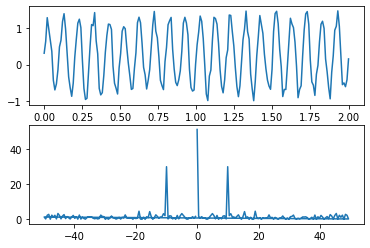

In [5]:
fig, ax = plt.subplots(2)

f = 10
t = np.linspace(0, 2, 200)
noise = np.random.rand(t.shape[0]) * 0.5
signal = np.sin(2 * np.pi * f * t) + noise

sp = np.fft.fft(signal)
freq = np.fft.fftfreq(t.shape[0], t[1] - t[0])

ax[0].plot(t, signal)
ax[1].plot(freq, np.abs(sp.real))

In [11]:
from scipy.sparse import csc_matrix

def plot_template(cell, savefig=False):
    with h5py.File(templates_file, 'r') as pot:
        #spikes = spks['/spiketimes/'+key][...].flatten()/samplerate
        temp_x = pot['temp_x'][:].ravel()
        temp_y = pot['temp_y'][:].ravel() # Cell-identifier
        temp_data = pot['temp_data'][:].ravel()
        N_e, N_t, nb_templates = pot['temp_shape'][:].ravel().astype(np.int32)

        temp = temp_data[temp_y == cell]
        
        if np.max(-temp) >= np.max(temp):
            temp /= np.max(-temp)
        else:
            temp /= -np.max(temp)
                    
        # Ojo a las células al revés ej: 826 y 827
        #temp /= np.max(-temp)
        pos_peak_thr = 0.1
        neg_peak_thr = 0.5
        cross_thr = -0.5

        neg_peaks,_ = find_peaks(-temp, height=neg_peak_thr)

        p_min = neg_peaks[np.argmin(temp[neg_peaks])]

        # Plotting every template of the cell
        fig, ax = plt.subplots(2)    
        ax[0].plot(temp)
        ax[0].plot(p_min, temp[p_min], 'o')
        ax[0].axvspan(p_min - 50, p_min + 50, alpha=0.3, color='green')
        ax[0].set_title('{}, temp_{} templates'.format(exp_name, cell))

        # Extract most negative peak template
        if p_min < 50:
            p_temp = np.concatenate((np.zeros(50 - p_min), temp[:p_min + 51]))
        elif p_min + 50 >= len(temp):
            p_temp = np.concatenate((temp[p_min - 50:], np.zeros(50 - (len(temp) - p_min) + 1)))
        else:
            p_temp = temp[p_min - 50 : p_min + 51]

        p_min = 50

        # Positive peaks
        pre_peaks0, _ = find_peaks(p_temp[:50], height=pos_peak_thr)
        pp0 = pre_peaks0[np.argmax(p_temp[pre_peaks0])]

        pre_peaks1, _ = find_peaks(p_temp[51:], height=pos_peak_thr)
        pre_peaks1 += 51
        pp1 = pre_peaks1[np.argmax(p_temp[pre_peaks1])]

        # Crossing -0.5 potential. Linear regression to estimate "exact" frame
        pc0 = np.argmax(p_temp[:51] < cross_thr) 
        pc1 = np.argmax(p_temp[51:] > cross_thr) + 51

        m0 = p_temp[pc0] - p_temp[pc0 - 1]
        a0 = p_temp[pc0] - m0 * pc0

        m1 = p_temp[pc1] - p_temp[pc1 - 1]
        a1 = p_temp[pc1] - m1 * pc1

        # "Exact" crossing frame.
        _pc0 = (-0.5 - a0) / m0
        _pc1 = (-0.5 - a1) / m1
        
        # Time references from negative peak
        # (Frame_cross - Frame_negative) / 20000.0 * 1000.0 [ms]
        SNR = 20 * np.log10(np.max(np.abs(p_temp)) / np.mean(np.abs(p_temp)))
                
        cross_time0 = (_pc0 - 50) / 20.0
        cross_time1 = (_pc1 - 50) / 20.0
        cross_diff = cross_time1 - cross_time0
        
        if savefig == False:
            if SNR >= 6.0:
                print('SNR: {:.4f}'.format(SNR))
            else:
                print('SNR: {:.4f} - DISCARDED'.format(SNR))

            print('1st cross {:.4f} [ms]'.format(cross_time0))
            print('2nd cross {:.4f} [ms]'.format(cross_time1))
            print('Cross diff {:.4f} [ms]\n'.format(cross_diff))

            print('1st pos-voltage {:.4f} units at {:.4f} [ms]'.format(p_temp[pp0], (pp0 - 50) / 20.0))
            print('2st pos-voltage {:.4f} units at {:.4f} [ms]'.format(p_temp[pp1], (pp1 - 50) / 20.0))

        # Plotting selected template and most negative peak
        #fig, ax = plt.subplots()
        ax[1].plot(p_temp)
        ax[1].plot(p_min, p_temp[p_min], 'o')

        # Plotting positive peaks
        ax[1].plot(pp0, p_temp[pp0], 'o', color='green')
        ax[1].plot(pp1, p_temp[pp1], 'o', color='green')

        # Plotting "exact" frames of -0.5 potential crossing
        ax[1].plot(_pc0, -0.5, 'o', color='purple')
        ax[1].plot(_pc1, -0.5, 'o', color='purple')
        ax[1].set_title('Template selected')
        plt.tight_layout()
        
        #if savefig == True:

interact(plot_template,
         cell=Dropdown(options=np.arange(0, 890)),
         savefig=fixed(False));

interactive(children=(Dropdown(description='cell', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

252 101 890


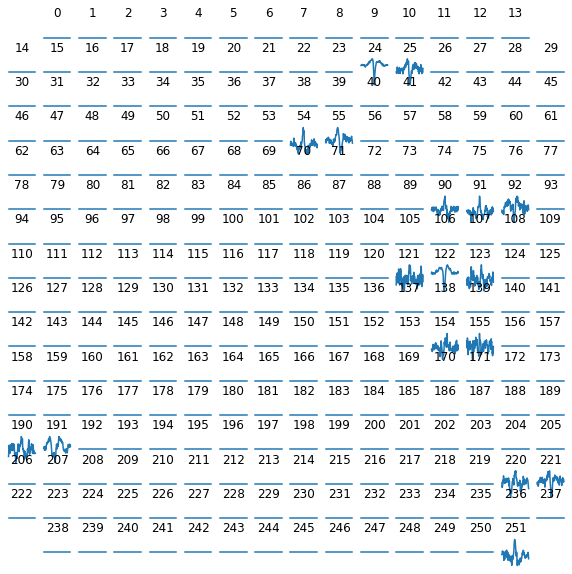

In [124]:
from scipy.sparse import csc_matrix

with h5py.File(templates_file, 'r') as pot:
    #spikes = spks['/spiketimes/'+key][...].flatten()/samplerate
    temp_x = pot['temp_x'][:].ravel()
    temp_y = pot['temp_y'][:].ravel()
    temp_data = pot['temp_data'][:].ravel()
    N_e, N_t, nb_templates = pot['temp_shape'][:].ravel().astype(np.int32)
    
    templates = csc_matrix((temp_data, (temp_x, temp_y)), shape=(N_e * N_t, nb_templates))
    
    shape = pot['temp_shape'][:].flatten()
    
    temp = templates[:, 0].toarray().reshape(N_e, N_t) # To read the template i as a 2D matrix
    
    print(N_e, N_t, nb_templates)
    
    #fig, ax = plt.subplots(3)
    #ax[0].plot(templates[:, 700].toarray().ravel())
    #ax[1].plot(templates[:, 700].toarray().ravel()[temp_x[(temp_x < 4000)*(temp_y == 0)]])
    #ax[2].plot(temp_data[temp_y == 700])
    
    #ax[0].plot(temp[24])
    #ax[1].plot(templates[:, 0].toarray().ravel())
    #ax[2].plot(templates[:, 2].toarray().ravel())
    
    fig, ax = plt.subplots(16, 16, figsize=(10, 10))
    count = 0
    row_idx = 0
    col_idx = 0
    
    for row in ax:
        col_idx = 0
        for draw in row:
            draw.set_axis_off()
            if (row_idx, col_idx) == (0, 0) or (row_idx, col_idx) == (0, 15) or (row_idx, col_idx) == (15, 0) or (row_idx, col_idx) == (15, 15):
                col_idx += 1
                continue
            
            draw.plot(temp[count, :])
            draw.set_title('{:d}'.format(count))
            
            col_idx += 1
            count += 1
        row_idx += 1 